In [1]:
#!wget https://cernbox.cern.ch/index.php/s/Vv8ET5qnpcus9Xg/download -O /opt/workspace/persistent-storage/dbs.pkl

In [2]:

#!wget https://cernbox.cern.ch/index.php/s/LZP5bK2EbeTYp4a/download  -O /opt/workspace/persistent-storage/accesses.pkl

In [10]:
import pandas as pd

df_dbs = pd.read_pickle('/opt/workspace/persistent-storage/dbs.pkl')
df_total = pd.read_pickle('/opt/workspace/persistent-storage/accesses.pkl')


In [11]:
#df_dbs['DATA_TIER'] = df_dbs['DESIRED_CMSDataset'].str.rsplit("/").str[-1]
#df_dbs[df_dbs['sum(d_is_dataset_valid)']>0].groupby('DATA_TIER')['sum(b_block_size)'].sum()

In [12]:
df_total = df_total.join(df_dbs.set_index('DESIRED_CMSDataset'), on='DESIRED_CMSDataset', how='inner')

In [11]:
df_total.head()

,DESIRED_CMSDataset,CRAB_UserHN,CRAB_Workflow,CMSSWMajorVersion,CMSSWReleaseSeries,count,date,DATA_TIER,sum(d_is_dataset_valid),sum(b_block_size)
0,/ZeroBias/Run2017E-09Aug2019_UL2017-v1/AOD,vmariani,200701_103327:vmariani_crab_DS4b_min_UL17_RunE...,10_X_X,10_6_X,1137,2020-07-01,AOD,93,1.828615e+13
64,/ZeroBias/Run2017E-09Aug2019_UL2017-v1/AOD,vmariani,200612_074012:vmariani_crab_DS4b_piu_UL17_HP_R...,10_X_X,10_6_X,1274,2020-07-01,AOD,93,1.828615e+13
2805,/ZeroBias/Run2017E-09Aug2019_UL2017-v1/AOD,vmariani,200601_132748:vmariani_crab_DS4b_min_UL17_RunE...,10_X_X,10_6_X,1132,2020-07-01,AOD,93,1.828615e+13
4016,/ZeroBias/Run2017E-09Aug2019_UL2017-v1/AOD,vmariani,200709_145435:vmariani_crab_DS4b_piu_UL17_HP_R...,10_X_X,10_6_X,1373,2020-07-09,AOD,93,1.828615e+13
6590,/ZeroBias/Run2017E-09Aug2019_UL2017-v1/AOD,kskovpen,200830_074709:kskovpen_crab_ZeroBias_Run2017E__1,10_X_X,10_6_X,1011,2020-08-30,AOD,93,1.828615e+13


# Weekly active rolling working set

In [13]:
def sum_unique(a):
        return a.to_frame().drop_duplicates().sum()

In [14]:
df_tmp = df_total[df_total["DATA_TIER"].isin(['MINIAOD','MINIAODSIM'])].set_index('date').sort_index().rolling('7d')['sum(b_block_size)'].apply(sum_unique).reset_index()
df_tmp_nano = df_total[df_total["DATA_TIER"].isin(['NANOAOD','NANOAODSIM'])].set_index('date').sort_index().rolling('7d')['sum(b_block_size)'].apply(sum_unique).reset_index()
df_tmp_user = df_total[df_total["DATA_TIER"].isin(['USER'])].set_index('date').sort_index().rolling('7d')['sum(b_block_size)'].apply(sum_unique).reset_index()

<AxesSubplot:xlabel='date'>

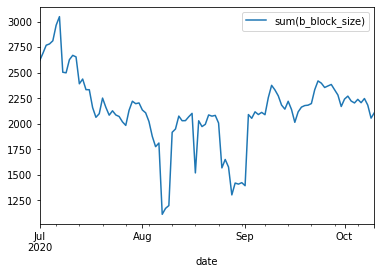

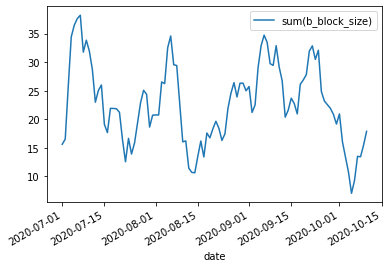

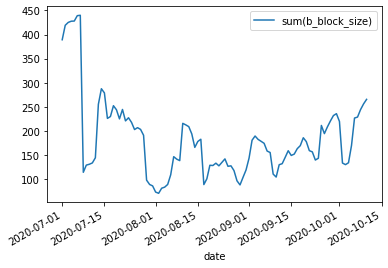

In [15]:
(df_tmp.groupby('date').max()/1e12).plot()
(df_tmp_nano.groupby('date').max()/1e12).plot()
(df_tmp_user.groupby('date').max()/1e12).plot()

# Montly active rolling working set

In [16]:
df_tmp = df_total[df_total["DATA_TIER"].isin(['MINIAOD','MINIAODSIM'])].set_index('date').sort_index().rolling('30d')['sum(b_block_size)'].apply(sum_unique).reset_index()
df_tmp_nano = df_total[df_total["DATA_TIER"].isin(['NANOAOD','NANOAODSIM'])].set_index('date').sort_index().rolling('30d')['sum(b_block_size)'].apply(sum_unique).reset_index()
df_tmp_user = df_total[df_total["DATA_TIER"].isin(['USER'])].set_index('date').sort_index().rolling('30d')['sum(b_block_size)'].apply(sum_unique).reset_index()

<AxesSubplot:xlabel='date'>

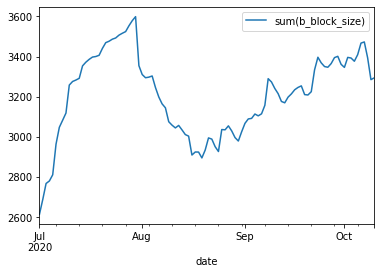

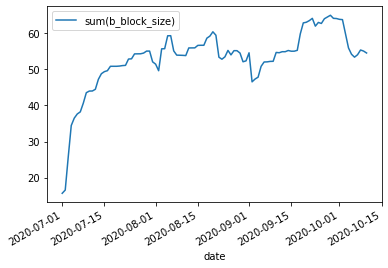

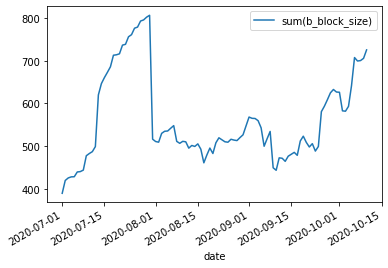

In [17]:
(df_tmp.groupby('date').max()/1e12).plot()
(df_tmp_nano.groupby('date').max()/1e12).plot()
(df_tmp_user.groupby('date').max()/1e12).plot()

# WEEKLY DATA ROTATION

In [14]:
df_mini = df_total[df_total["DATA_TIER"].isin(['MINIAOD','MINIAODSIM'])].set_index('date').sort_index()


In [54]:
df_tmp = df_mini.reset_index().groupby(['DESIRED_CMSDataset', pd.Grouper(key='date', freq='1W')])['sum(b_block_size)'].max()\
    .reset_index().set_index('date').sort_index()

In [55]:
df_tmp_shift_plus = df_tmp.shift(periods=7, freq="D").reset_index()[['date', 'DESIRED_CMSDataset','sum(b_block_size)']]

In [56]:
df_merge = df_tmp.reset_index().merge(df_tmp_shift_plus, on=['date','DESIRED_CMSDataset'], how="left", suffixes=['_right','_left'])

<AxesSubplot:xlabel='date'>

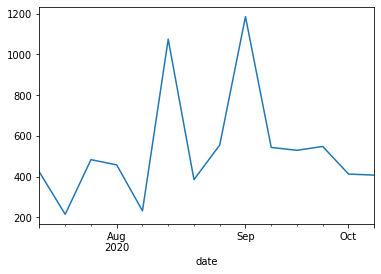

In [57]:
(df_merge[df_merge['sum(b_block_size)_left'].isnull()].drop_duplicates(subset=['date','DESIRED_CMSDataset']).groupby('date')['sum(b_block_size)_right'].sum()/1e12)[1:].plot()

# 15 DAYS DATA ROTATION

In [58]:
df_tmp = df_mini.reset_index().groupby(['DESIRED_CMSDataset', pd.Grouper(key='date', freq='15D')])['sum(b_block_size)'].max()\
    .reset_index().set_index('date').sort_index()

df_tmp_shift_plus = df_tmp.shift(periods=15, freq="D").reset_index()[['date', 'DESIRED_CMSDataset','sum(b_block_size)']]

In [59]:
df_merge = df_tmp.reset_index().merge(df_tmp_shift_plus, on=['date','DESIRED_CMSDataset'], how="left", suffixes=['_right','_left'])

<AxesSubplot:xlabel='date'>

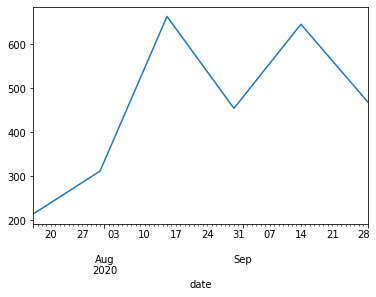

In [60]:
(df_merge[df_merge['sum(b_block_size)_left'].isnull()].drop_duplicates(subset=['date','DESIRED_CMSDataset']).groupby('date')['sum(b_block_size)_right'].sum()/1e12)[1:].plot()

# 30 DAYS DATA ROTATION

In [61]:
df_tmp = df_mini.reset_index().groupby(['DESIRED_CMSDataset', pd.Grouper(key='date', freq='30D')])['sum(b_block_size)'].max()\
    .reset_index().set_index('date').sort_index()

df_tmp_shift_plus = df_tmp.shift(periods=30, freq="D").reset_index()[['date', 'DESIRED_CMSDataset','sum(b_block_size)']]

In [62]:
df_merge = df_tmp.reset_index().merge(df_tmp_shift_plus, on=['date','DESIRED_CMSDataset'], how="left", suffixes=['_right','_left'])

<AxesSubplot:xlabel='date'>

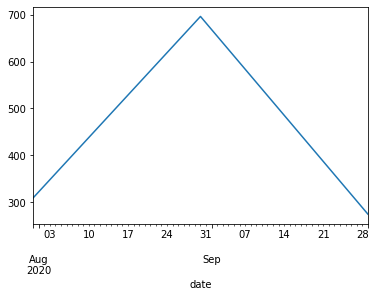

In [63]:
(df_merge[df_merge['sum(b_block_size)_left'].isnull()].drop_duplicates(subset=['date','DESIRED_CMSDataset']).groupby('date')['sum(b_block_size)_right'].sum()/1e12)[1:].plot()

# DAILY DATA ROTATION

In [74]:
df_tmp = df_mini.reset_index().groupby(['DESIRED_CMSDataset', pd.Grouper(key='date', freq='1D')])['sum(b_block_size)'].max()\
    .reset_index().set_index('date').sort_index()

df_tmp_shift_plus = df_tmp.shift(periods=1, freq="D").reset_index()[['date', 'DESIRED_CMSDataset','sum(b_block_size)']]

In [75]:
df_merge = df_tmp.reset_index().merge(df_tmp_shift_plus, on=['date','DESIRED_CMSDataset'], how="left", suffixes=['_right','_left'])

<AxesSubplot:xlabel='date'>

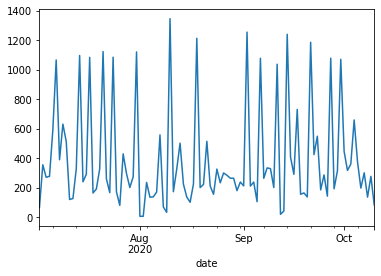

In [76]:
(df_merge[df_merge['sum(b_block_size)_left'].isnull()].drop_duplicates(subset=['date','DESIRED_CMSDataset']).groupby('date')['sum(b_block_size)_right'].sum()/1e12)[1:].plot()

# SIZE OF NEW DS W.R.T. FIRST MONTH 

In [81]:
df_tmp = df_mini[df_mini.index < "2020-08-01"].drop_duplicates(subset=['DESIRED_CMSDataset'])['DESIRED_CMSDataset'].to_list()

In [91]:
# DATA ACCESSED ON PREVIOUS MONTH
df_mini[df_mini.index < "2020-08-01"].drop_duplicates(subset=['DESIRED_CMSDataset'])['sum(b_block_size)'].sum()/1e12
#df_tmp

3468.36427179992

In [83]:
df_new = df_mini.reset_index().groupby(['DESIRED_CMSDataset', pd.Grouper(key='date', freq='1D')])['sum(b_block_size)'].max()\
    .reset_index().set_index('date').sort_index()

<AxesSubplot:xlabel='date'>

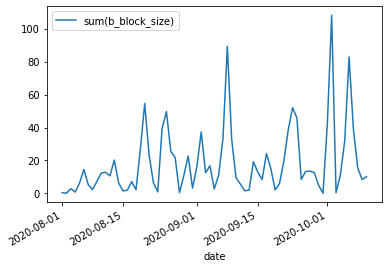

In [88]:
(df_new[~df_new['DESIRED_CMSDataset'].isin(df_tmp)].groupby('date').sum()/1e12).plot()

# INCREMENTAL DAILY NEW DATA W.R.T. PREVIOUS MONTH

In [108]:
df_tmp = df_mini.reset_index().groupby(['DESIRED_CMSDataset', pd.Grouper(key='date', freq='1D')])['sum(b_block_size)'].max()\
    .reset_index().set_index('date').sort_index()

In [109]:
df_tmp['DESIRED_CMSDataset']

date
2020-07-01    /ST_tW_antitop_5f_inclusiveDecays_TuneCP5_13Te...
2020-07-01    /GMSB_L-350TeV_Ctau-200cm_13TeV-pythia8/RunIIS...
2020-07-01    /GMSB_L-350TeV_Ctau-1200cm_13TeV-pythia8/RunII...
2020-07-01    /GMSB_L-350TeV_Ctau-10cm_13TeV-pythia8/RunIISu...
2020-07-01    /GMSB_L-350TeV_Ctau-1000cm_13TeV-pythia8/RunII...
                                    ...                        
2020-10-10    /QCD_Pt-800to1000_MuEnrichedPt5_TuneCP5_13TeV_...
2020-10-10    /QCD_Pt-800to1000_MuEnrichedPt5_TuneCUETP8M1_1...
2020-10-10    /QCD_Pt-800to1000_MuEnrichedPt5_TuneCUETP8M1_1...
2020-10-10    /QCD_Pt-80to120_EMEnriched_TuneCP5_13TeV_pythi...
2020-10-10     /Charmonium/Run2016H-21Feb2020_UL2016-v1/MINIAOD
Name: DESIRED_CMSDataset, Length: 26719, dtype: object

In [112]:
from datetime import timedelta


a = pd.date_range(start='7/1/2020', end='10/30/2020')

old_ds = []

data_points = []

data_sizes = []

for d in a:
    #print(d)
    df_new = df_mini[df_mini.index == d]

    mask = (df_mini.index > d - timedelta(days=30)) & (df_mini.index < d)
    old_ds = df_mini.loc[mask].drop_duplicates(subset=['DESIRED_CMSDataset'])['DESIRED_CMSDataset'].to_list()
    data_points.append(df_new[~df_new['DESIRED_CMSDataset'].isin(old_ds)].drop_duplicates(subset=['DESIRED_CMSDataset'])['sum(b_block_size)'].sum()/1e12)

    # Calculate data sizes
    mask = (df_mini.index > d - timedelta(days=30)) & (df_mini.index <= d)
    data_sizes.append(df_mini.loc[mask].drop_duplicates(subset=['DESIRED_CMSDataset'])['sum(b_block_size)'].sum()/1e12)


<AxesSubplot:xlabel='date'>

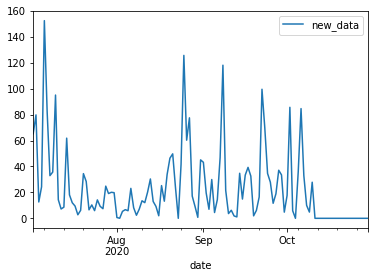

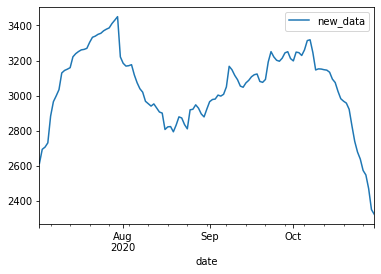

In [113]:
df_dict = {'date': a, 'new_data': data_points}

pd.DataFrame(df_dict).set_index('date')[1:].plot()

df_dict = {'date': a, 'new_data': data_sizes}

pd.DataFrame(df_dict).set_index('date')[1:].plot()